<font color='green'><center><h1> Deep Learning-Based Image Captioning </h1></center>

<font color='purple'><center><h1> Table of Contents </h1></center>

### Table of Contents

* [Import Module](#chapter1)
    * [Import the Libraries](#section_1_1)
    * [Importing the Dataset](section_1_2)
* [Data Preprocessing](#chapter2)
* [Data Visualizationn](#chapter3) 
* [Model Building](#chapter4)
    * [Define the Functions](#section_4_1)
    * [Set-up the VGG16 model](#section_4_2)
    * [Model Training](#section_4_3)
* [Model Testing](#chapter5)
    * [Splitting the Dataset](#section_5_1)
    * [Data Preprocessing](#section_5_2)
    * [Model Tweaking](#section_5_3)
    * [Model Training - Run Epochs](#section_5_4)
    * [Plot Loss and Accuracy](#section_5_5)
    * [Predict Captions](#section_5_6)
* [Model Evaluation](#chapter6)
* [Inferences and Comments](#chapter7)

<font color='purple'><center><h1> Import Module </h1></center>

<font color='blue'><center><h2> Import the Libraries </h2></center>

In [24]:
# importing the packages necessary for this assignment problem

import numpy as np
import pandas as pd
import math
import os
import timeit
import cv2
import progressbar
import string
import time

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#for checking testing results
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

# Import visualization libraries
from matplotlib import pyplot as plt
plt.rc("font", size=14)
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import AutoLocator, MaxNLocator, LinearLocator, MultipleLocator, FixedLocator, NullLocator

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# and we want to view the charts inline
%matplotlib inline

# Import deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import layers
from keras.regularizers import l2
from keras import models

from nltk.translate.bleu_score import sentence_bleu

import pickle
from collections import Counter
from collections import OrderedDict 
from copy import copy

TensorFlow version: 2.8.2


<font color='blue'><center><h2> Importing the Dataset </h2></center>

In [25]:
# Mount BITS Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Initializing the path of the dataset

dir_Flickr_jpg = "/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset/"
jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker30k: {}".format(len(jpgs)))

The number of jpg flies in Flicker30k: 8111


In [28]:
# Read the data from the pickle file

with open('/content/drive/MyDrive/Colab Notebooks/set_0.pkl', 'rb') as file_id:
  data = pickle.load(file_id)

In [29]:
# View the contents of the pickle file

print('AFTER:  ',data)

AFTER:   ['318667317_108c402140.jpg#4\tA man in a black hoodie be hold a paper sign .', '2072574835_febf0c5fb9.jpg#4\tThree race dog be run out of the start gate on a track .', '3083016677_5782bc337c.jpg#4\tTwo motorcycle with two rider each .', '95734038_2ab5783da7.jpg#0\tA man on a bike nest to a river .', '241346146_f27759296d.jpg#1\tA football player try tackle another player who have the ball .', '3182405529_7692256746.jpg#2\tan old man with long gray hair and a long gray beard bike ride on the shore .', '3278777548_290b881018.jpg#1\tFour person walk on a bridge over a body of water .', '3621717946_d96f8a6012.jpg#3\tTwo swimmer be play a water sport with a yellow ball and a net .', '3542425197_2ef81c6051.jpg#1\tA woman in white lighting talk to a man light in green .', '3384742888_85230c34d5.jpg#3\tDog chew up ball while roll in grass', '514036362_5f2b9b7314.jpg#0\tA girl wear a black top be smile with a silver truck in the background .', '3331797838_b3e33dbe17.jpg#3\tTwo person r

<font color='purple'><center><h1> Data Preprocessing </h1></center>

In [30]:
# Convert the pickle file to the required dataframe format

df_pre = pd.DataFrame(data)
df_pre.to_csv(r'results.csv')
df_pre.columns = ['full_text']
df_pre.head()

full_text
0  318667317_108c402140.jpg#4\tA man in a black h...
1  2072574835_febf0c5fb9.jpg#4\tThree race dog be...
2  3083016677_5782bc337c.jpg#4\tTwo motorcycle wi...
3  95734038_2ab5783da7.jpg#0\tA man on a bike nes...
4  241346146_f27759296d.jpg#1\tA football player ...

In [31]:
# Separate the image name
df_split = df_pre.full_text.str.split(pat='#',expand=True)
df_split.columns = ['image_name', 'split', 'none']
# df_split.head()

# Separate the comment number and comment/caption
df_split2 = df_split.split.str.split(pat='\t',expand=True)
df_split2.columns = ['comment_number', 'comment']
# df_split2.head()

# Combine the necessary items in one dataframe
df_split['split'] = df_split2['comment_number'].copy()
df_split['none'] = df_split2['comment'].copy()
df_split.columns = ['image_name', 'comment_number', 'comment']
# df_split.head()

train_captions = df_split.copy()
train_captions.tail()

image_name comment_number  \
24995  2993388841_6746140656.jpg              3   
24996  3578372039_57473f473c.jpg              1   
24997  3186073578_6e115f45f5.jpg              0   
24998  2653552905_4301449235.jpg              3   
24999  3719461451_07de35af3a.jpg              0   

                                                 comment  
24995  A basketball player in a blue uniform be guard...  
24996  A young man ride a skateboard and carry large ...  
24997                       A man display a photograph .  
24998  Two man stand in front of a condominium buildi...  
24999                     A pelican fly over the water .

<font color='purple'><center><h1> Data Visualization </h1></center>

In [32]:
# Print the number of unique number of file names
uniq_filenames = np.unique(train_captions.image_name.values)
print("The number of unique file names : {}".format(len(uniq_filenames)))

# Print the top 4 words
print("The distribution of the number of captions for each image:")
Counter(Counter(train_captions.image_name.values).values())

The number of unique file names : 8037
The distribution of the number of captions for each image:


Counter({4: 2239, 3: 2745, 2: 1744, 5: 753, 1: 556})

In [33]:
npic = 5
npix = 224
target_size = (npix,npix,3)

print("Display the Pictures and Captions")

count = 1
fig = plt.figure(figsize=(10,20))

for jpgfnm in uniq_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_split["comment"].loc[df_split["image_name"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

Display the Pictures and Captions


<font color='purple'><center><h1> Model Building </h1></center>

<font color='blue'><center><h2> Define the Functions </h2></center>

In [49]:
# Function to remove the punctuation
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

# Function to remove single characters
def remove_single_character(text):
    text_len_more_than_1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than_1 += " " + word
    return(text_len_more_than_1)

# Function to remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

# Function to clean the text - calls the other subfunctions
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

# Display the progress bar
with progressbar.ProgressBar(max_value=len(df_split.comment.values)) as bar:
    for i, caption in enumerate(df_split.comment.values):
        newcaption = text_clean(caption)
        df_split["comment"].iloc[i] = newcaption
        bar.update(i)

# Function to add START and STOP
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' stopseq'
        caps.append(txt)
    return(caps)

df_txt0 = copy(df_split)
df_txt0["comment"] = add_start_end_seq_token(df_split["comment"])
df_txt0.head(5)
# del df_split

100% (25000 of 25000) |##################| Elapsed Time: 0:00:07 Time:  0:00:07


image_name comment_number  \
0   318667317_108c402140.jpg              4   
1  2072574835_febf0c5fb9.jpg              4   
2  3083016677_5782bc337c.jpg              4   
3    95734038_2ab5783da7.jpg              0   
4   241346146_f27759296d.jpg              1   

                                             comment  
0  startseq  man in black hoodie be hold paper si...  
1  startseq  Three race dog be run out of the sta...  
2  startseq  Two motorcycle with two rider each s...  
3        startseq  man on bike nest to river stopseq  
4  startseq  football player try tackle another p...

<font color='blue'><center><h2> Set-up the VGG16 model </h2></center>

In [36]:
modelvgg = VGG16(weights='imagenet')
print(modelvgg.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<font color='blue'><center><h2> Model Training </h2></center>

In [37]:
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)

with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)

100% (8111 of 8111) |####################| Elapsed Time: 0:56:51 Time:  0:56:51


In [38]:
dimages, keepindex = [],[]
nd=(df_txt0["comment_number"].values)
b = [(int(i)==0) for i in nd]

df_txt0 = df_txt0.loc[df_txt0["comment_number"].values == "0",: ]

for i, fnm in enumerate(df_txt0.image_name):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["image_name"].iloc[keepindex].values
dcaptions = df_txt0["comment"].iloc[keepindex].values
dimages = np.array(dimages)

print(df_txt0["comment_number"][:5])

3     0
10    0
13    0
21    0
23    0
Name: comment_number, dtype: object


In [39]:
# Find the maximum number of words in dictionary
count_words=22000
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 2785
[[1, 9, 6, 70, 1482, 21, 302, 2], [1, 14, 32, 13, 127, 4, 98, 11, 510, 359, 3, 8, 128, 2], [1, 645, 232, 27, 3, 878, 292, 132, 135, 2], [1, 120, 54, 209, 8, 38, 2], [1, 184, 645, 232, 5, 23, 3, 8, 43, 11, 115, 3, 72, 62, 2]]


<font color='purple'><center><h1> Model Testing </h1></center>

<font color='blue'><center><h2> Splitting the Dataset </h2></center>

In [40]:
prop_test, prop_val = 0.1, 0.1 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

# Split the dataset into testing and validation sets
def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

maxlen = np.max([len(text) for text in dtexts])

<font color='blue'><center><h2> Data Preprocessing </h2></center>

In [41]:
# Function to preprocess the data

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)

# Preprocess the data
Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4012
 (40505, 28) (40505, 1000) (40505, 2785)
# captions/images = 501
 (5005, 28) (5005, 1000) (5005, 2785)


<font color='blue'><center><h2> Model Tweaking </h2></center>

In [42]:
print(vocab_size)

dim_embedding = 64

# Adding dropout layer
input_image = layers.Input(shape=(Ximage_train.shape[1],))
droplayer1 = layers.Dropout(0.5)(input_image)
BN = layers.BatchNormalization()(droplayer1)

# Add L2 Regularization to every layer
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature1",kernel_regularizer=l2(0.01))(BN)
droplayer1 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer1)
fimage1 = layers.Dense(256,activation='relu',name="ImageFeature3",kernel_regularizer=l2(0.01))(BN)
droplayer2 = layers.Dropout(0.5)(fimage1)
BN = layers.BatchNormalization()(droplayer2)
fimage2 = layers.Dense(256, activation='relu')(BN)


# Create the sequence model - Encoder
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
droplayer_ = layers.Dropout(0.5)(ftxt)
BN = layers.BatchNormalization()(droplayer_)
ftxt = layers.LSTM(256,name="CaptionFeature")(BN)


# Create the combined model - Decoder
decoder = layers.add([ftxt,fimage2])
decoder = layers.Dense(256,activation='relu')(decoder)
droplayer1 = layers.Dropout(0.5)(decoder)
BN = layers.BatchNormalization()(droplayer1)
output = layers.Dense(vocab_size,activation='softmax')(BN)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

# Add an activation function
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

2785
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1000)         0           ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1000)        4000        ['dropout[0][0]']                
 alization)                                                                                       
                                                                                                  
 ImageFeature1 (Dense)          (None, 256)          256256      ['batch_normalization[0]

<font color='blue'><center><h2> Model Training - Run Epochs </h2></center>

In [44]:
start = time.time()
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,monitor = 'val_accuracy',mode='max', verbose=2)

hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=100, verbose=2, batch_size=250,
                  validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks = [cp_callback])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/100

Epoch 1: saving model to training_1


163/163 - 63s - loss: 3.7507 - accuracy: 0.2869 - val_loss: 4.1545 - val_accuracy: 0.2825 - 63s/epoch - 388ms/step
Epoch 2/100

Epoch 2: saving model to training_1


163/163 - 60s - loss: 3.7289 - accuracy: 0.2892 - val_loss: 4.1678 - val_accuracy: 0.2901 - 60s/epoch - 370ms/step
Epoch 3/100

Epoch 3: saving model to training_1


163/163 - 61s - loss: 3.6533 - accuracy: 0.2918 - val_loss: 4.1757 - val_accuracy: 0.2909 - 61s/epoch - 376ms/step
Epoch 4/100

Epoch 4: saving model to training_1


163/163 - 60s - loss: 3.5803 - accuracy: 0.2980 - val_loss: 4.1463 - val_accuracy: 0.2963 - 60s/epoch - 371ms/step
Epoch 5/100

Epoch 5: saving model to training_1


163/163 - 61s - loss: 3.5349 - accuracy: 0.2996 - val_loss: 4.1806 - val_accuracy: 0.2933 - 61s/epoch - 375ms/step
Epoch 6/100

Epoch 6: saving model to training_1


163/163 - 61s - loss: 3.4715 - accuracy: 0.3041 - val_loss: 4.1511 - val_accuracy: 0.2967 - 61s/epoch - 374ms/step
Epoch 7/100

Epoch 7: saving model to training_1


163/163 - 60s - loss: 3.4538 - accuracy: 0.3057 - val_loss: 4.1758 - val_accuracy: 0.2923 - 60s/epoch - 370ms/step
Epoch 8/100

Epoch 8: saving model to training_1


163/163 - 61s - loss: 3.4205 - accuracy: 0.3079 - val_loss: 4.1797 - val_accuracy: 0.2977 - 61s/epoch - 373ms/step
Epoch 9/100

Epoch 9: saving model to training_1


163/163 - 61s - loss: 3.3450 - accuracy: 0.3107 - val_loss: 4.1818 - val_accuracy: 0.2953 - 61s/epoch - 375ms/step
Epoch 10/100

Epoch 10: saving model to training_1


163/163 - 61s - loss: 3.3593 - accuracy: 0.3128 - val_loss: 4.2084 - val_accuracy: 0.2993 - 61s/epoch - 374ms/step
Epoch 11/100

Epoch 11: saving model to training_1


163/163 - 60s - loss: 3.2977 - accuracy: 0.3189 - val_loss: 4.2137 - val_accuracy: 0.2993 - 60s/epoch - 370ms/step
Epoch 12/100

Epoch 12: saving model to training_1


163/163 - 62s - loss: 3.2349 - accuracy: 0.3187 - val_loss: 4.2287 - val_accuracy: 0.2965 - 62s/epoch - 378ms/step
Epoch 13/100

Epoch 13: saving model to training_1


163/163 - 60s - loss: 3.1965 - accuracy: 0.3227 - val_loss: 4.2472 - val_accuracy: 0.2999 - 60s/epoch - 370ms/step
Epoch 14/100

Epoch 14: saving model to training_1


163/163 - 62s - loss: 3.1942 - accuracy: 0.3251 - val_loss: 4.2499 - val_accuracy: 0.3015 - 62s/epoch - 377ms/step
Epoch 15/100

Epoch 15: saving model to training_1


163/163 - 61s - loss: 3.1909 - accuracy: 0.3263 - val_loss: 4.2667 - val_accuracy: 0.3007 - 61s/epoch - 372ms/step
Epoch 16/100

Epoch 16: saving model to training_1


163/163 - 62s - loss: 3.1101 - accuracy: 0.3307 - val_loss: 4.2642 - val_accuracy: 0.3031 - 62s/epoch - 378ms/step
Epoch 17/100

Epoch 17: saving model to training_1


163/163 - 61s - loss: 3.0658 - accuracy: 0.3339 - val_loss: 4.2859 - val_accuracy: 0.3033 - 61s/epoch - 372ms/step
Epoch 18/100

Epoch 18: saving model to training_1


163/163 - 61s - loss: 3.0552 - accuracy: 0.3380 - val_loss: 4.2928 - val_accuracy: 0.3007 - 61s/epoch - 376ms/step
Epoch 19/100

Epoch 19: saving model to training_1


163/163 - 60s - loss: 3.0956 - accuracy: 0.3358 - val_loss: 4.3388 - val_accuracy: 0.2983 - 60s/epoch - 370ms/step
Epoch 20/100

Epoch 20: saving model to training_1


163/163 - 61s - loss: 3.0237 - accuracy: 0.3401 - val_loss: 4.3381 - val_accuracy: 0.3025 - 61s/epoch - 377ms/step
Epoch 21/100

Epoch 21: saving model to training_1


163/163 - 61s - loss: 3.0044 - accuracy: 0.3443 - val_loss: 4.3698 - val_accuracy: 0.3003 - 61s/epoch - 373ms/step
Epoch 22/100

Epoch 22: saving model to training_1


163/163 - 62s - loss: 3.0684 - accuracy: 0.3424 - val_loss: 4.4135 - val_accuracy: 0.2979 - 62s/epoch - 380ms/step
Epoch 23/100

Epoch 23: saving model to training_1


163/163 - 60s - loss: 2.9605 - accuracy: 0.3483 - val_loss: 4.4104 - val_accuracy: 0.3013 - 60s/epoch - 370ms/step
Epoch 24/100

Epoch 24: saving model to training_1


163/163 - 62s - loss: 2.9459 - accuracy: 0.3507 - val_loss: 4.4173 - val_accuracy: 0.3041 - 62s/epoch - 379ms/step
Epoch 25/100

Epoch 25: saving model to training_1


163/163 - 62s - loss: 2.9043 - accuracy: 0.3514 - val_loss: 4.4330 - val_accuracy: 0.3007 - 62s/epoch - 380ms/step
Epoch 26/100

Epoch 26: saving model to training_1


163/163 - 60s - loss: 2.9200 - accuracy: 0.3566 - val_loss: 4.5055 - val_accuracy: 0.2975 - 60s/epoch - 370ms/step
Epoch 27/100

Epoch 27: saving model to training_1


163/163 - 62s - loss: 2.9196 - accuracy: 0.3540 - val_loss: 4.4841 - val_accuracy: 0.3023 - 62s/epoch - 380ms/step
Epoch 28/100

Epoch 28: saving model to training_1


163/163 - 61s - loss: 2.8418 - accuracy: 0.3597 - val_loss: 4.4990 - val_accuracy: 0.2973 - 61s/epoch - 375ms/step
Epoch 29/100

Epoch 29: saving model to training_1


163/163 - 62s - loss: 2.8365 - accuracy: 0.3604 - val_loss: 4.4889 - val_accuracy: 0.3005 - 62s/epoch - 380ms/step
Epoch 30/100

Epoch 30: saving model to training_1


163/163 - 61s - loss: 2.8724 - accuracy: 0.3598 - val_loss: 4.5434 - val_accuracy: 0.3055 - 61s/epoch - 374ms/step
Epoch 31/100

Epoch 31: saving model to training_1


163/163 - 62s - loss: 2.8187 - accuracy: 0.3635 - val_loss: 4.5223 - val_accuracy: 0.2991 - 62s/epoch - 377ms/step
Epoch 32/100

Epoch 32: saving model to training_1


163/163 - 61s - loss: 2.7859 - accuracy: 0.3722 - val_loss: 4.5445 - val_accuracy: 0.2999 - 61s/epoch - 375ms/step
Epoch 33/100

Epoch 33: saving model to training_1


163/163 - 62s - loss: 2.8264 - accuracy: 0.3689 - val_loss: 4.5952 - val_accuracy: 0.3001 - 62s/epoch - 379ms/step
Epoch 34/100

Epoch 34: saving model to training_1


163/163 - 60s - loss: 2.7593 - accuracy: 0.3733 - val_loss: 4.6133 - val_accuracy: 0.3021 - 60s/epoch - 366ms/step
Epoch 35/100

Epoch 35: saving model to training_1


163/163 - 61s - loss: 2.7808 - accuracy: 0.3726 - val_loss: 4.6265 - val_accuracy: 0.3017 - 61s/epoch - 375ms/step
Epoch 36/100

Epoch 36: saving model to training_1


163/163 - 60s - loss: 2.8309 - accuracy: 0.3688 - val_loss: 4.6607 - val_accuracy: 0.3039 - 60s/epoch - 371ms/step
Epoch 37/100

Epoch 37: saving model to training_1


163/163 - 62s - loss: 2.7607 - accuracy: 0.3744 - val_loss: 4.6622 - val_accuracy: 0.3019 - 62s/epoch - 378ms/step
Epoch 38/100

Epoch 38: saving model to training_1


163/163 - 60s - loss: 2.7816 - accuracy: 0.3781 - val_loss: 4.7107 - val_accuracy: 0.3039 - 60s/epoch - 371ms/step
Epoch 39/100

Epoch 39: saving model to training_1


163/163 - 62s - loss: 2.7402 - accuracy: 0.3767 - val_loss: 4.7145 - val_accuracy: 0.3023 - 62s/epoch - 377ms/step
Epoch 40/100

Epoch 40: saving model to training_1


163/163 - 60s - loss: 2.7053 - accuracy: 0.3821 - val_loss: 4.7245 - val_accuracy: 0.2967 - 60s/epoch - 369ms/step
Epoch 41/100

Epoch 41: saving model to training_1


163/163 - 61s - loss: 2.6797 - accuracy: 0.3831 - val_loss: 4.7235 - val_accuracy: 0.3035 - 61s/epoch - 376ms/step
Epoch 42/100

Epoch 42: saving model to training_1


163/163 - 61s - loss: 2.6366 - accuracy: 0.3895 - val_loss: 4.7362 - val_accuracy: 0.3015 - 61s/epoch - 377ms/step
Epoch 43/100

Epoch 43: saving model to training_1


163/163 - 61s - loss: 2.6265 - accuracy: 0.3901 - val_loss: 4.7192 - val_accuracy: 0.2991 - 61s/epoch - 372ms/step
Epoch 44/100

Epoch 44: saving model to training_1


163/163 - 61s - loss: 2.6832 - accuracy: 0.3860 - val_loss: 4.7620 - val_accuracy: 0.2957 - 61s/epoch - 373ms/step
Epoch 45/100

Epoch 45: saving model to training_1


163/163 - 60s - loss: 2.7454 - accuracy: 0.3898 - val_loss: 4.8629 - val_accuracy: 0.2965 - 60s/epoch - 371ms/step
Epoch 46/100

Epoch 46: saving model to training_1


163/163 - 61s - loss: 2.6418 - accuracy: 0.3910 - val_loss: 4.8419 - val_accuracy: 0.2971 - 61s/epoch - 376ms/step
Epoch 47/100

Epoch 47: saving model to training_1


163/163 - 60s - loss: 2.5963 - accuracy: 0.3951 - val_loss: 4.8303 - val_accuracy: 0.2973 - 60s/epoch - 370ms/step
Epoch 48/100

Epoch 48: saving model to training_1


163/163 - 61s - loss: 2.5974 - accuracy: 0.3991 - val_loss: 4.8366 - val_accuracy: 0.3017 - 61s/epoch - 374ms/step
Epoch 49/100

Epoch 49: saving model to training_1


163/163 - 60s - loss: 2.6446 - accuracy: 0.3951 - val_loss: 4.8733 - val_accuracy: 0.2985 - 60s/epoch - 370ms/step
Epoch 50/100

Epoch 50: saving model to training_1


163/163 - 61s - loss: 2.6520 - accuracy: 0.3964 - val_loss: 4.9023 - val_accuracy: 0.2983 - 61s/epoch - 375ms/step
Epoch 51/100

Epoch 51: saving model to training_1


163/163 - 60s - loss: 2.6713 - accuracy: 0.3944 - val_loss: 4.9226 - val_accuracy: 0.2993 - 60s/epoch - 370ms/step
Epoch 52/100

Epoch 52: saving model to training_1


163/163 - 62s - loss: 2.5841 - accuracy: 0.4013 - val_loss: 4.8938 - val_accuracy: 0.3019 - 62s/epoch - 383ms/step
Epoch 53/100

Epoch 53: saving model to training_1


163/163 - 60s - loss: 2.5650 - accuracy: 0.4025 - val_loss: 4.9017 - val_accuracy: 0.2957 - 60s/epoch - 370ms/step
Epoch 54/100

Epoch 54: saving model to training_1


163/163 - 61s - loss: 2.5843 - accuracy: 0.4012 - val_loss: 4.9636 - val_accuracy: 0.2975 - 61s/epoch - 376ms/step
Epoch 55/100

Epoch 55: saving model to training_1


163/163 - 60s - loss: 2.5282 - accuracy: 0.4063 - val_loss: 4.9569 - val_accuracy: 0.2949 - 60s/epoch - 368ms/step
Epoch 56/100

Epoch 56: saving model to training_1


163/163 - 61s - loss: 2.5443 - accuracy: 0.4072 - val_loss: 4.9511 - val_accuracy: 0.2975 - 61s/epoch - 373ms/step
Epoch 57/100

Epoch 57: saving model to training_1


163/163 - 63s - loss: 2.5444 - accuracy: 0.4086 - val_loss: 4.9423 - val_accuracy: 0.2961 - 63s/epoch - 386ms/step
Epoch 58/100

Epoch 58: saving model to training_1


163/163 - 61s - loss: 2.5359 - accuracy: 0.4095 - val_loss: 4.9776 - val_accuracy: 0.2993 - 61s/epoch - 372ms/step
Epoch 59/100

Epoch 59: saving model to training_1


163/163 - 61s - loss: 2.4688 - accuracy: 0.4173 - val_loss: 5.0099 - val_accuracy: 0.2997 - 61s/epoch - 374ms/step
Epoch 60/100

Epoch 60: saving model to training_1


163/163 - 60s - loss: 2.4762 - accuracy: 0.4184 - val_loss: 4.9926 - val_accuracy: 0.2959 - 60s/epoch - 370ms/step
Epoch 61/100

Epoch 61: saving model to training_1


163/163 - 62s - loss: 2.5044 - accuracy: 0.4119 - val_loss: 5.0043 - val_accuracy: 0.2993 - 62s/epoch - 378ms/step
Epoch 62/100

Epoch 62: saving model to training_1


163/163 - 60s - loss: 2.5120 - accuracy: 0.4152 - val_loss: 5.0626 - val_accuracy: 0.2959 - 60s/epoch - 368ms/step
Epoch 63/100

Epoch 63: saving model to training_1


163/163 - 61s - loss: 2.4574 - accuracy: 0.4191 - val_loss: 5.0391 - val_accuracy: 0.2967 - 61s/epoch - 373ms/step
Epoch 64/100

Epoch 64: saving model to training_1


163/163 - 60s - loss: 2.4829 - accuracy: 0.4225 - val_loss: 5.1287 - val_accuracy: 0.2961 - 60s/epoch - 367ms/step
Epoch 65/100

Epoch 65: saving model to training_1


163/163 - 61s - loss: 2.4635 - accuracy: 0.4233 - val_loss: 5.1343 - val_accuracy: 0.2971 - 61s/epoch - 374ms/step
Epoch 66/100

Epoch 66: saving model to training_1


163/163 - 60s - loss: 2.4575 - accuracy: 0.4221 - val_loss: 5.1089 - val_accuracy: 0.2979 - 60s/epoch - 369ms/step
Epoch 67/100

Epoch 67: saving model to training_1


163/163 - 61s - loss: 2.4195 - accuracy: 0.4283 - val_loss: 5.1598 - val_accuracy: 0.2959 - 61s/epoch - 372ms/step
Epoch 68/100

Epoch 68: saving model to training_1


163/163 - 60s - loss: 2.4219 - accuracy: 0.4258 - val_loss: 5.1408 - val_accuracy: 0.2971 - 60s/epoch - 370ms/step
Epoch 69/100

Epoch 69: saving model to training_1


163/163 - 61s - loss: 2.4830 - accuracy: 0.4221 - val_loss: 5.1714 - val_accuracy: 0.2969 - 61s/epoch - 373ms/step
Epoch 70/100

Epoch 70: saving model to training_1


163/163 - 60s - loss: 2.4230 - accuracy: 0.4256 - val_loss: 5.2046 - val_accuracy: 0.3015 - 60s/epoch - 370ms/step
Epoch 71/100

Epoch 71: saving model to training_1


163/163 - 61s - loss: 2.4187 - accuracy: 0.4288 - val_loss: 5.2005 - val_accuracy: 0.2951 - 61s/epoch - 375ms/step
Epoch 72/100

Epoch 72: saving model to training_1


163/163 - 61s - loss: 2.4830 - accuracy: 0.4311 - val_loss: 5.2467 - val_accuracy: 0.2969 - 61s/epoch - 373ms/step
Epoch 73/100

Epoch 73: saving model to training_1


163/163 - 60s - loss: 2.4454 - accuracy: 0.4284 - val_loss: 5.1984 - val_accuracy: 0.2977 - 60s/epoch - 368ms/step
Epoch 74/100

Epoch 74: saving model to training_1


163/163 - 61s - loss: 2.3610 - accuracy: 0.4373 - val_loss: 5.1930 - val_accuracy: 0.2967 - 61s/epoch - 374ms/step
Epoch 75/100

Epoch 75: saving model to training_1


163/163 - 60s - loss: 2.3738 - accuracy: 0.4351 - val_loss: 5.1951 - val_accuracy: 0.2983 - 60s/epoch - 367ms/step
Epoch 76/100

Epoch 76: saving model to training_1


163/163 - 61s - loss: 2.3437 - accuracy: 0.4437 - val_loss: 5.2821 - val_accuracy: 0.2961 - 61s/epoch - 374ms/step
Epoch 77/100

Epoch 77: saving model to training_1


163/163 - 60s - loss: 2.3722 - accuracy: 0.4349 - val_loss: 5.2490 - val_accuracy: 0.2971 - 60s/epoch - 369ms/step
Epoch 78/100

Epoch 78: saving model to training_1


163/163 - 61s - loss: 2.4166 - accuracy: 0.4336 - val_loss: 5.2602 - val_accuracy: 0.2937 - 61s/epoch - 374ms/step
Epoch 79/100

Epoch 79: saving model to training_1


163/163 - 60s - loss: 2.3558 - accuracy: 0.4403 - val_loss: 5.2626 - val_accuracy: 0.2989 - 60s/epoch - 365ms/step
Epoch 80/100

Epoch 80: saving model to training_1


163/163 - 61s - loss: 2.3405 - accuracy: 0.4399 - val_loss: 5.2778 - val_accuracy: 0.2967 - 61s/epoch - 374ms/step
Epoch 81/100

Epoch 81: saving model to training_1


163/163 - 60s - loss: 2.4342 - accuracy: 0.4338 - val_loss: 5.3231 - val_accuracy: 0.2989 - 60s/epoch - 370ms/step
Epoch 82/100

Epoch 82: saving model to training_1


163/163 - 61s - loss: 2.3331 - accuracy: 0.4436 - val_loss: 5.2888 - val_accuracy: 0.2967 - 61s/epoch - 374ms/step
Epoch 83/100

Epoch 83: saving model to training_1


163/163 - 60s - loss: 2.3360 - accuracy: 0.4395 - val_loss: 5.3136 - val_accuracy: 0.2989 - 60s/epoch - 369ms/step
Epoch 84/100

Epoch 84: saving model to training_1


163/163 - 61s - loss: 2.2992 - accuracy: 0.4450 - val_loss: 5.3411 - val_accuracy: 0.2903 - 61s/epoch - 376ms/step
Epoch 85/100

Epoch 85: saving model to training_1


163/163 - 61s - loss: 2.3746 - accuracy: 0.4454 - val_loss: 5.3974 - val_accuracy: 0.2953 - 61s/epoch - 372ms/step
Epoch 86/100

Epoch 86: saving model to training_1


163/163 - 60s - loss: 2.3533 - accuracy: 0.4425 - val_loss: 5.3536 - val_accuracy: 0.2895 - 60s/epoch - 368ms/step
Epoch 87/100

Epoch 87: saving model to training_1


163/163 - 61s - loss: 2.3650 - accuracy: 0.4436 - val_loss: 5.3495 - val_accuracy: 0.2941 - 61s/epoch - 372ms/step
Epoch 88/100

Epoch 88: saving model to training_1


163/163 - 60s - loss: 2.3754 - accuracy: 0.4408 - val_loss: 5.4088 - val_accuracy: 0.2935 - 60s/epoch - 371ms/step
Epoch 89/100

Epoch 89: saving model to training_1


163/163 - 61s - loss: 2.3123 - accuracy: 0.4514 - val_loss: 5.3939 - val_accuracy: 0.2941 - 61s/epoch - 373ms/step
Epoch 90/100

Epoch 90: saving model to training_1


163/163 - 60s - loss: 2.4137 - accuracy: 0.4395 - val_loss: 5.4130 - val_accuracy: 0.2955 - 60s/epoch - 369ms/step
Epoch 91/100

Epoch 91: saving model to training_1


163/163 - 61s - loss: 2.3263 - accuracy: 0.4462 - val_loss: 5.4130 - val_accuracy: 0.2917 - 61s/epoch - 374ms/step
Epoch 92/100

Epoch 92: saving model to training_1


163/163 - 60s - loss: 2.2701 - accuracy: 0.4487 - val_loss: 5.4107 - val_accuracy: 0.2893 - 60s/epoch - 369ms/step
Epoch 93/100

Epoch 93: saving model to training_1


163/163 - 61s - loss: 2.2797 - accuracy: 0.4580 - val_loss: 5.4706 - val_accuracy: 0.2897 - 61s/epoch - 375ms/step
Epoch 94/100

Epoch 94: saving model to training_1


163/163 - 60s - loss: 2.3725 - accuracy: 0.4513 - val_loss: 5.5430 - val_accuracy: 0.2993 - 60s/epoch - 367ms/step
Epoch 95/100

Epoch 95: saving model to training_1


163/163 - 61s - loss: 2.3381 - accuracy: 0.4516 - val_loss: 5.5287 - val_accuracy: 0.2943 - 61s/epoch - 376ms/step
Epoch 96/100

Epoch 96: saving model to training_1


163/163 - 61s - loss: 2.4100 - accuracy: 0.4474 - val_loss: 5.5156 - val_accuracy: 0.2919 - 61s/epoch - 373ms/step
Epoch 97/100

Epoch 97: saving model to training_1


163/163 - 61s - loss: 2.3204 - accuracy: 0.4571 - val_loss: 5.5036 - val_accuracy: 0.2959 - 61s/epoch - 375ms/step
Epoch 98/100

Epoch 98: saving model to training_1


163/163 - 60s - loss: 2.3113 - accuracy: 0.4514 - val_loss: 5.4988 - val_accuracy: 0.2901 - 60s/epoch - 369ms/step
Epoch 99/100

Epoch 99: saving model to training_1


163/163 - 60s - loss: 2.2539 - accuracy: 0.4577 - val_loss: 5.4968 - val_accuracy: 0.2937 - 60s/epoch - 369ms/step
Epoch 100/100

Epoch 100: saving model to training_1


163/163 - 61s - loss: 2.3508 - accuracy: 0.4558 - val_loss: 5.5616 - val_accuracy: 0.2941 - 61s/epoch - 375ms/step
TIME TOOK 101.40MIN


In [45]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(40505, 1000) (40505, 28) (40505, 2785)


<font color='blue'><center><h2> Plot Loss and Accuracy </h2></center>

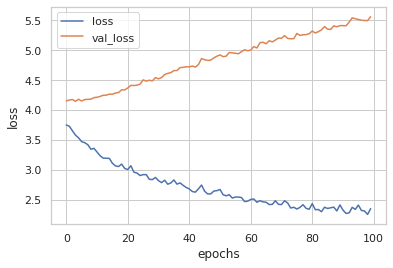

In [46]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

<font color='blue'><center><h2> Predict Captions </h2></center>

In [50]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''
    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "stopseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

<font color='purple'><center><h1> Model Evaluation </h1></center>

In [51]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 20
pred_good, pred_bad, bleus = [], [], [] 
count = 0 

for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] # remove startreg, and endreg

    # captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1] # remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.5 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

  39.92% is done..
  79.84% is done..


In [53]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

In [54]:
print("Incorrect Captions")
plot_images(pred_bad)

Bad Caption


Good Caption


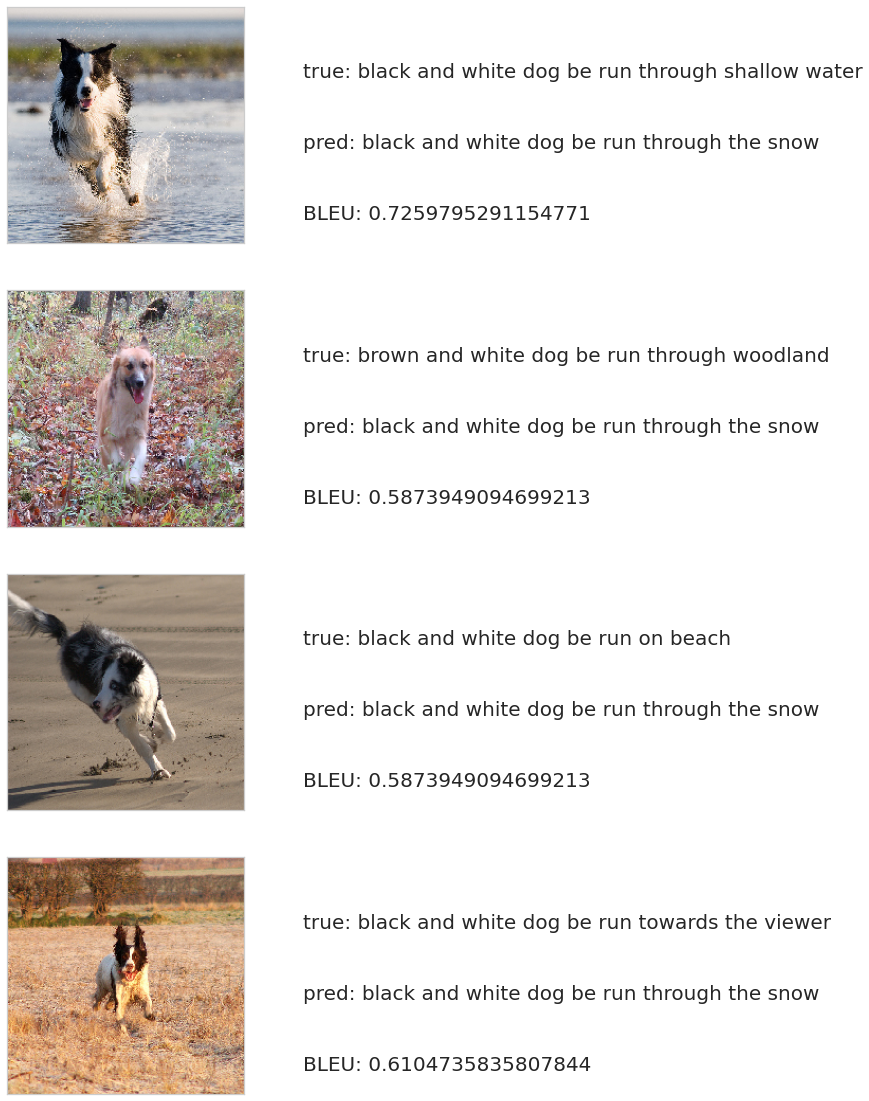

In [55]:
print("More Accurate Captions")
plot_images(pred_good)

<font color='purple'><center><h1> Inferences & Comments </h1></center>

<font color='green'> <b> Explanations </b> <br><br>
<i> <ul style="list-style-type:disc"> 
<li> The results of the Adam optimizer are generally better than every other optimization algorithms, have faster computation time, and require fewer parameters for tuning. Because of all that, Adam is recommended as the default optimizer for most of the applications. </li><br>
<li> The model has used Adam optimizer with 3 hidden layers and gave ~50% accuracy. One layer dropout was added and l2 regularization was applied to all layers.</li><br>